In [30]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from collections import OrderedDict
from IPython.display import display
from joblib import dump, load
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import make_regression
from sklearn.pipeline import Pipeline

import ipyparallel as ipp
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import itertools

import MESS
from MESS.util import set_params

## Set some pandas options to show the full rows and columns of a DF
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

## Where do you want the simulation output to life?
analysis_dir = "/home/iovercast/Continuosity/MESS/analysis/"
analysis_dir = analysis_dir + "/full-parameter-estimation/"
if not os.path.exists(analysis_dir):
    os.mkdir(analysis_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
ipyclient = ipp.Client(cluster_id="MESS-Rich")
print(len(ipyclient))

40


In [32]:
r = MESS.Region("whole_enchilada")
## Region params
r.set_param("project_dir", analysis_dir)
r.set_param("generations", 0)
r.set_param("community_assembly_model", "*")
r.set_param("mutation_rate", 2.2e-8)
r.set_param("alpha", (500, 5000))

## Metacommunity Params
r.set_param("S_m", 500)
r.set_param("J_m", (5e4, 5e6))
r.set_param("speciation_rate", 2)
r.set_param("death_proportion", 0.7)
r.set_param("trait_rate_meta", 2)
r.set_param("ecological_strength", (1, 10))

## Local Params
r.set_param("J", 1000)
r.set_param("m", (0.001, 0.01))
r.set_param("speciation_prob", (0.0001, 0.001))

r.write_params(full=True, force=True)
#r.run(sims=1000, ipyclient=ipyclient)

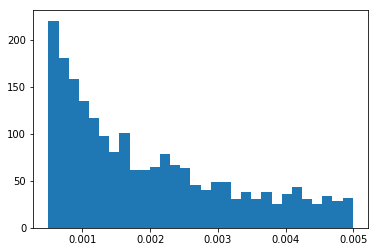

In [47]:

analysis_dir = "/home/iovercast/Continuosity/MESS/analysis/figure5-sims/"
sim_file = analysis_dir + "fig5_sims/SIMOUT.txt"

sim_df = pd.read_csv(sim_file, sep="\t", header=0)
_, _, _ = plt.hist(sim_df["speciation_prob"], bins=30)

714
716
630


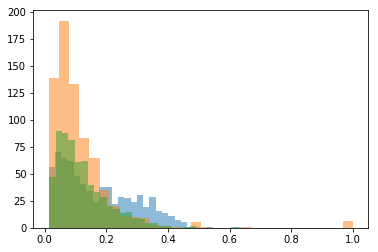

In [48]:
neut_df = sim_df[sim_df["community_assembly_model"] == "neutral"]
filt_df = sim_df[sim_df["community_assembly_model"] == "filtering"]
comp_df = sim_df[sim_df["community_assembly_model"] == "competition"]
for df in [neut_df, filt_df, comp_df]:
    print(len(df))
    plt.hist(df["abund_h1"]/df["S"], alpha=.5, bins=30)


In [64]:
def get_best_params(Xtrain, ytrain, n_iter=100):
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]
    random_grid = {'n_estimators': n_estimators,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    ## Randomly search 100 different parameter combinations and take the
    ## one that reduces CV error
    rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(),\
                                   param_distributions = random_grid,
                                   n_iter = n_iter, cv = 3, verbose=0, n_jobs = -1)
    rf_random.fit(Xtrain, ytrain)
    return rf_random.best_estimator_

def plot_cv_pred(y, cv_preds, targets, verbose=False):
    fig, axs = plt.subplots(2, 3, figsize=(10, 5))
    axs = axs.flatten()
    lims = {"m":0.01, "speciation_prob":0.005}
    for i, p in enumerate(targets):
        ax = axs[i]
        vscore = metrics.explained_variance_score(y.iloc[:, i], cv_preds[:, i])
        r2 = metrics.r2_score(y.iloc[:, i], cv_preds[:, i])
        if verbose: print("\tparam: {}\tvscore: {}\tr2: {}".format(p, vscore, r2))
        if p == "ecological_strength":
            ax.scatter(np.log(y.iloc[:, i]), cv_preds[:, i], c='black', marker='.', s=2)
        else:
            ax.scatter(y.iloc[:, i], cv_preds[:, i], c='black', marker='.', s=2)
        ax.set_title(p)
        if p in ["m", "speciation_prob"]:
            ax.set_xlim(0, lims[p])
            ax.set_ylim(0, lims[p])
    return fig

In [29]:
feature_sets = MESS.stats.feature_sets()
for i, (f, features) in enumerate(feature_sets.items()):
    print(i, f, len(features))

(0, 'abundance', 5)
(1, 'pi', 20)
(2, 'dxy', 6)
(3, 'trait', 10)
(4, 'abundance+pi', 26)
(5, 'pi+dxy', 27)
(6, 'pi+trait', 31)
(7, 'abundance+trait', 16)
(8, 'abundance+pi+trait', 38)
(9, 'all', 48)


In [ ]:
## be smarter to add a codeblock here to run, generate the analysis directories per model,
## train the RF, and then dump it to a file, then in the following block we can just load
## in the pre-trained model and throw data at it. Saves time.

In [68]:

outdir = analysis_dir + "cv_figs/"
if not os.path.exists(outdir):
    os.mkdir(outdir)
targets = ["alpha", "J", "ecological_strength", "m", "speciation_prob", "_lambda"]

## Infile is the input SIMOUT file. model_name is either neutral, comp, or filt
## for labeling the figures
def joint_param_cv(infile, outdir=outdir, model_name='', use_features=["abund"],
                   n_iter=100, n_samps=1e6, verbose=False):
    model_outdir = os.path.join(outdir, model_name)
    if not os.path.exists(model_outdir):
        os.mkdir(model_outdir)
    n_samps=int(n_samps)
    sim_df = pd.read_csv(infile, sep="\t", header=0)
    sim_df = sim_df[sim_df["community_assembly_model"] == model_name]
    print("Model: {}\tTotal sims: {}\t Sims to use: {}\t N param CV iters: {}".format(model_name, len(sim_df), n_samps, n_iter))
    imp_out_df = pd.DataFrame([], index=feature_sets["all"])
    
    for f in use_features:
        features = feature_sets[f]
        X = sim_df[features][:n_samps]
        y = sim_df[targets][:n_samps]
        Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)
        print("{}: Finding best model params".format(f))
        model = get_best_params(Xtrain, ytrain, n_iter=n_iter)
        print("{}: Best params - {}".format(f, model.get_params()))
        dump(model, "{}/{}.mdl".format(model_outdir, f)) 
        feat_imp_df = pd.DataFrame(model.feature_importances_, index=features, columns=[f])
        imp_out_df = pd.concat([imp_out_df, feat_imp_df], axis=1, sort=False)
        #display(feat_imp_df.sort_values(0, ascending=False).T)
        cv_preds = cross_val_predict(model, X, y, cv=5, n_jobs=-1)
        fig = plot_cv_pred(y, cv_preds, targets, verbose=verbose)
        plt.suptitle(f)
        plt.tight_layout()
        plt.savefig("{}/{}.png".format(model_outdir, f))
    imp_out_df.to_csv(model_outdir + model_name + "_feature_importance.csv", sep="\t")



Model: neutral	Total sims: 714	 Sims to use: 1000	 N param CV iters: 2
all: Finding best model params


/home/iovercast/miniconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


all: Best params - {'warm_start': False, 'oob_score': False, 'n_jobs': None, 'min_impurity_decrease': 0.0, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 2000, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'mse', 'random_state': None, 'min_impurity_split': None, 'max_features': 'auto', 'max_depth': 20}
	param: alpha	vscore: 0.556522721386	r2: 0.556238791316
	param: J	vscore: 0.710386602031	r2: 0.710381632439
	param: ecological_strength	vscore: -0.0210354644484	r2: -0.0210460394441
	param: m	vscore: 0.258503245996	r2: 0.258502090812
	param: speciation_prob	vscore: 0.523054160566	r2: 0.52296216645
	param: _lambda	vscore: 0.665741866113	r2: 0.665677127812


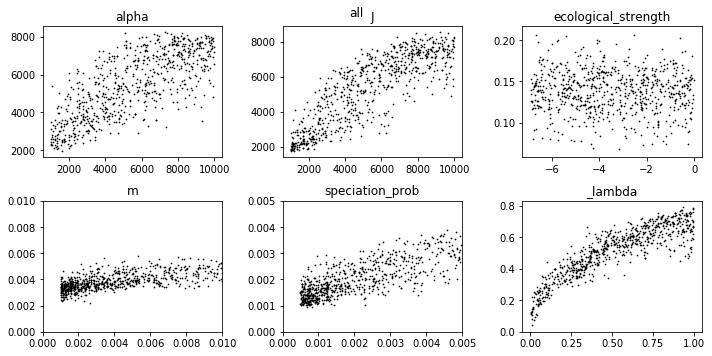

In [69]:
## Make these params v small for prototyping
n_iter=2
n_samps=1000
joint_param_cv(infile=sim_file, outdir=outdir, model_name="neutral",
               n_iter=n_iter, n_samps=n_samps, use_features=["all"], verbose=True)

## Do all the big joint parameter estimation CVs and plots
We're going to do serious CV now, so set the n_iter and n_samps to reasonably large vals.

Model: neutral	Total sims: 714	 Sims to use: 10000	 N param CV iters: 100
all: Finding best model params
all: Best params - {'warm_start': False, 'oob_score': False, 'n_jobs': None, 'min_impurity_decrease': 0.0, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 1600, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'mse', 'random_state': None, 'min_impurity_split': None, 'max_features': 'auto', 'max_depth': 20}
	param: alpha	vscore: 0.565144160903	r2: 0.564812179084
	param: J	vscore: 0.726174660214	r2: 0.726174188531
	param: ecological_strength	vscore: -0.0364774525491	r2: -0.0364866761818
	param: m	vscore: 0.329107628622	r2: 0.329008051014
	param: speciation_prob	vscore: 0.562029513485	r2: 0.561431363715
	param: _lambda	vscore: 0.742368742416	r2: 0.741710240112
Model: filtering	Total sims: 716	 Sims to use: 10000	 N param CV iters: 100
all: Finding best model params
all: Best params - {'warm_start': False, 'oob_score':

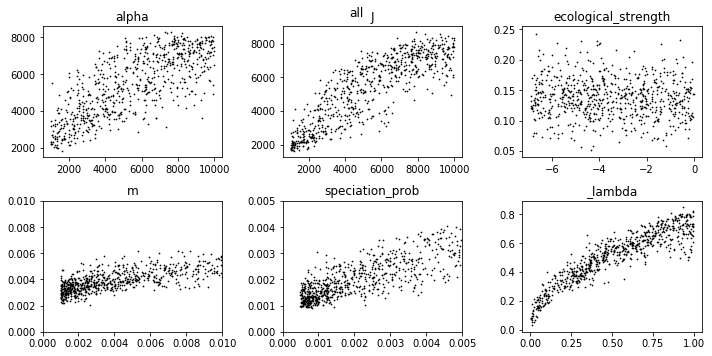

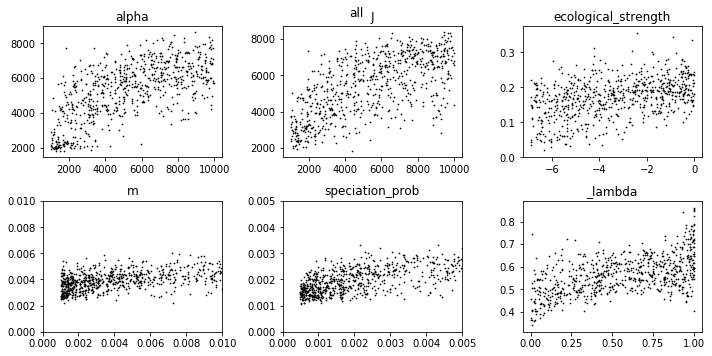

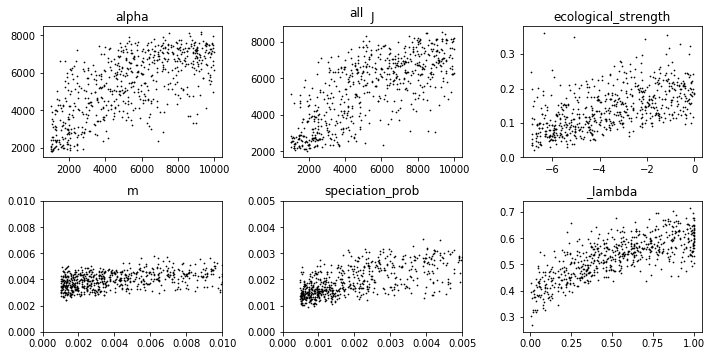

In [70]:
n_iter=100
n_samps=10000
for model in ["neutral", "filtering", "competition"]:
    joint_param_cv(infile=sim_file, outdir=outdir, model_name=model,
                   n_iter=n_iter, n_samps=n_samps, use_features=["all"], verbose=True)

## Estimate each parameter independently

In [71]:

outdir = analysis_dir + "independent_cv_figs/"
if not os.path.exists(outdir):
    os.mkdir(outdir)
targets = ["alpha", "J", "ecological_strength", "m", "speciation_prob", "_lambda"]

def plot_independent_cv_pred(ax, y, cv_preds, target_label, verbose=False):

    lims = {"m":0.01, "speciation_prob":0.005}
    vscore = metrics.explained_variance_score(y, cv_preds)
    r2 = metrics.r2_score(y, cv_preds)
    if verbose: print("\tparam: {}\tvscore: {}\tr2: {}".format(target_label, vscore, r2))
    ax.scatter(y, cv_preds, c='black', marker='.', s=2)
    ax.set_title(target_label)
    if target_label in ["m", "speciation_prob"]:
        ax.set_xlim(0, lims[target_label])
        ax.set_ylim(0, lims[target_label])

## Infile is the input SIMOUT file. model_name is either neutral, comp, or filt
## for labeling the figures
def independent_param_cv(infile, outdir=outdir, model_name='', use_features=["abund"],
                   n_iter=100, n_samps=1e6, verbose=False):
    model_outdir = os.path.join(outdir, model_name)
    if not os.path.exists(model_outdir):
        os.mkdir(model_outdir)
    n_samps=int(n_samps)
    sim_df = pd.read_csv(infile, sep="\t", header=0)
    sim_df = sim_df[sim_df["community_assembly_model"] == model_name]
    print("Model: {}\tTotal sims: {}\t Sims to use: {}\t N param CV iters: {}".format(model_name, len(sim_df), n_samps, n_iter))
    imp_out_df = pd.DataFrame([], index=feature_sets["all"])
    
    for f in use_features:
        ## Here we know there are six targets
        fig, axs = plt.subplots(2, 3, figsize=(10, 5))
        axs = axs.flatten()
        features = feature_sets[f]
        for fidx, target in enumerate(targets):
            X = sim_df[features][:n_samps]
            y = sim_df[target][:n_samps]
            Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)
            print("{} {}: Finding best model params".format(f, target))
            model = get_best_params(Xtrain, ytrain, n_iter=n_iter)
            print("{} {}: Best params - {}".format(f, target, model.get_params()))
            dump(model, "{}/{}_{}.mdl".format(model_outdir, f, target)) 
            feat_imp_df = pd.DataFrame(model.feature_importances_, index=features, columns=[f])
            imp_out_df = pd.concat([imp_out_df, feat_imp_df], axis=1, sort=False)
            #display(feat_imp_df.sort_values(0, ascending=False).T)
            cv_preds = cross_val_predict(model, X, y, cv=5, n_jobs=-1)
            fig = plot_independent_cv_pred(axs[fidx], y, cv_preds, target_label=target, verbose=verbose)
            plt.suptitle(f)
            plt.tight_layout()
            plt.savefig("{}/{}.png".format(model_outdir, f))
        imp_out_df.to_csv("{}/{}_{}_feature_importance.csv".format(model_outdir, model_name, f), sep="\t")

In [ ]:
## Make these params v small for prototyping
n_iter=100
n_samps=1000
for model in ["neutral", "filtering", "competition"]:
    independent_param_cv(infile=sim_file, outdir=outdir, model_name=model,\
                     use_features=["all"], n_iter=n_iter, n_samps=n_samps, verbose=True)

Model: neutral	Total sims: 714	 Sims to use: 1000	 N param CV iters: 100
all alpha: Finding best model params


/home/iovercast/miniconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


all alpha: Best params - {'warm_start': False, 'oob_score': False, 'n_jobs': None, 'min_impurity_decrease': 0.0, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 1200, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'criterion': 'mse', 'random_state': None, 'min_impurity_split': None, 'max_features': 'auto', 'max_depth': 20}
	param: alpha	vscore: 0.595200264464	r2: 0.595167723082
all J: Finding best model params


/home/iovercast/miniconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


all J: Best params - {'warm_start': False, 'oob_score': False, 'n_jobs': None, 'min_impurity_decrease': 0.0, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 1400, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'mse', 'random_state': None, 'min_impurity_split': None, 'max_features': 'auto', 'max_depth': 30}
	param: J	vscore: 0.786240749438	r2: 0.786240605232
all ecological_strength: Finding best model params


/home/iovercast/miniconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


all ecological_strength: Best params - {'warm_start': False, 'oob_score': False, 'n_jobs': None, 'min_impurity_decrease': 0.0, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 200, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'criterion': 'mse', 'random_state': None, 'min_impurity_split': None, 'max_features': 'auto', 'max_depth': 90}
	param: ecological_strength	vscore: -0.064096467469	r2: -0.0668741512276
all m: Finding best model params


/home/iovercast/miniconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


all m: Best params - {'warm_start': False, 'oob_score': False, 'n_jobs': None, 'min_impurity_decrease': 0.0, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 800, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'mse', 'random_state': None, 'min_impurity_split': None, 'max_features': 'auto', 'max_depth': 110}
	param: m	vscore: 0.534389976741	r2: 0.534329611747
all speciation_prob: Finding best model params


/home/iovercast/miniconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


all speciation_prob: Best params - {'warm_start': False, 'oob_score': False, 'n_jobs': None, 'min_impurity_decrease': 0.0, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 600, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'criterion': 'mse', 'random_state': None, 'min_impurity_split': None, 'max_features': 'auto', 'max_depth': 100}
	param: speciation_prob	vscore: 0.640926351622	r2: 0.640922920655
all _lambda: Finding best model params
all _lambda: Best params - {'warm_start': False, 'oob_score': False, 'n_jobs': None, 'min_impurity_decrease': 0.0, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 400, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'criterion': 'mse', 'random_state': None, 'min_impurity_split': None, 'max_features': 'auto', 'max_depth': 50}
	param: _lambda	vscore: 0.970985314785	r2: 0.97098095165
Model: filtering	Total sims: 716	 Sims to use: 1000	 N param

/home/iovercast/miniconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


all alpha: Best params - {'warm_start': False, 'oob_score': False, 'n_jobs': None, 'min_impurity_decrease': 0.0, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 1200, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'criterion': 'mse', 'random_state': None, 'min_impurity_split': None, 'max_features': 'auto', 'max_depth': 30}
	param: alpha	vscore: 0.4775388157	r2: 0.477507000554
all J: Finding best model params


/home/iovercast/miniconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


all J: Best params - {'warm_start': False, 'oob_score': False, 'n_jobs': None, 'min_impurity_decrease': 0.0, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 400, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'criterion': 'mse', 'random_state': None, 'min_impurity_split': None, 'max_features': 'auto', 'max_depth': 50}
	param: J	vscore: 0.543562187912	r2: 0.543505480994
all ecological_strength: Finding best model params


/home/iovercast/miniconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


all ecological_strength: Best params - {'warm_start': False, 'oob_score': False, 'n_jobs': None, 'min_impurity_decrease': 0.0, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 600, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'mse', 'random_state': None, 'min_impurity_split': None, 'max_features': 'auto', 'max_depth': 100}
	param: ecological_strength	vscore: 0.317637572502	r2: 0.31739083122
all m: Finding best model params


/home/iovercast/miniconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


all m: Best params - {'warm_start': False, 'oob_score': False, 'n_jobs': None, 'min_impurity_decrease': 0.0, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 600, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'mse', 'random_state': None, 'min_impurity_split': None, 'max_features': 'auto', 'max_depth': 20}


Model: neutral	Total sims: 5525	 Sims to use: 5000	 N param CV iters: 100
all alpha: Finding best model params
all alpha: Best params - {'warm_start': False, 'oob_score': False, 'n_jobs': None, 'min_impurity_decrease': 0.0, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 1800, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'mse', 'random_state': None, 'min_impurity_split': None, 'max_features': 'auto', 'max_depth': 70}
	param: alpha	vscore: 0.567275320203	r2: 0.567274108208
all J: Finding best model params
all J: Best params - {'warm_start': False, 'oob_score': False, 'n_jobs': None, 'min_impurity_decrease': 0.0, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 1200, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'criterion': 'mse', 'random_state': None, 'min_impurity_split': None, 'max_features': 'auto', 'max_depth': 80}
	param: J	vscore: 0.72275526774	r2: 0.

	param: speciation_prob	vscore: 0.481847205868	r2: 0.481809567482
all _lambda: Finding best model params
all _lambda: Best params - {'warm_start': False, 'oob_score': False, 'n_jobs': None, 'min_impurity_decrease': 0.0, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 2000, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'criterion': 'mse', 'random_state': None, 'min_impurity_split': None, 'max_features': 'auto', 'max_depth': 60}
	param: _lambda	vscore: 0.551053309788	r2: 0.551035026622


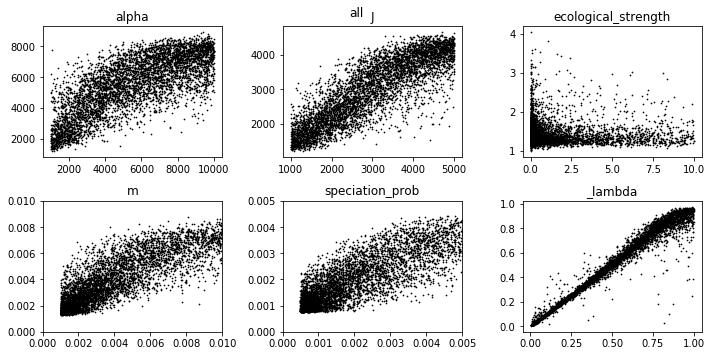

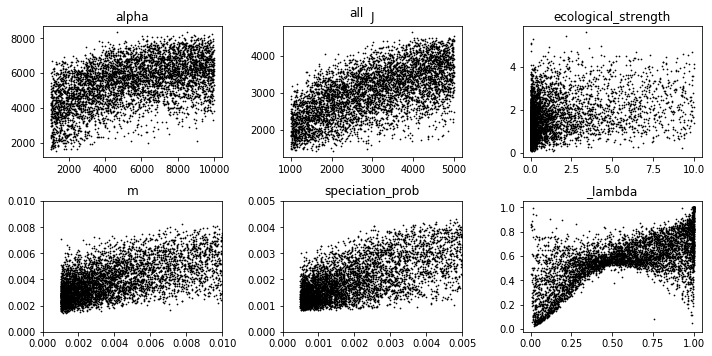

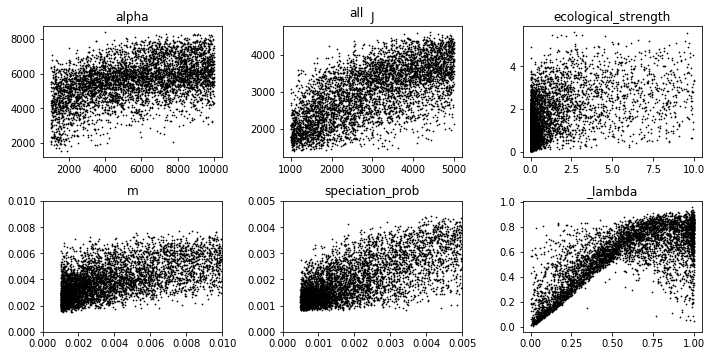

In [41]:
## Make these params v small for prototyping
n_iter=100
n_samps=5000
for model in ["neutral", "filtering", "competition"]:
    independent_param_cv(infile=sim_file, outdir=outdir, model_name=model,\
                     use_features=["all"], n_iter=n_iter, n_samps=n_samps, verbose=True)

## Dev below here
This is just prototyping of all the small chunks that got chunked together in the main codeblock above.

In [54]:
features = sim_df.iloc[:, 21:].columns

## Parameters to estimate
targets = ["alpha", "J_m", "ecological_strength", "m", "speciation_prob", "_lambda"]

X = sim_df[features]
y = sim_df[targets]

## Split the data
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)
display(Xtrain[:5])
display(ytrain[:5])

,S,abund_h1,abund_h2,abund_h3,abund_h4,pi_h1,pi_h2,pi_h3,pi_h4,mean_pi,std_pi,skewness_pi,kurtosis_pi,median_pi,iqr_pi,mean_dxys,std_dxys,skewness_dxys,kurtosis_dxys,median_dxys,iqr_dxys,trees,trait_h1,trait_h2,trait_h3,trait_h4,mean_local_traits,std_local_traits,skewness_local_traits,kurtosis_local_traits,median_local_traits,iqr_local_traits,mean_regional_traits,std_regional_traits,skewness_regional_traits,kurtosis_regional_traits,median_regional_traits,iqr_regional_traits,reg_loc_mean_trait_dif,reg_loc_std_trait_dif,reg_loc_skewness_trait_dif,reg_loc_kurtosis_trait_dif,reg_loc_median_trait_dif,reg_loc_iqr_trait_dif,abundance_dxy_cor,abundance_pi_cor,abundance_trait_cor,dxy_pi_cor,dxy_trait_cor,pi_trait_cor,SGD_0,SGD_1,SGD_2,SGD_3,SGD_4,SGD_5,SGD_6,SGD_7,SGD_8,SGD_9
1287,30.0,2.03609,1.59762,1.48583,1.43227,4.14674,3.45723,3.01910,2.76566,0.00014,0.00038,3.51181,12.78549,0.00000,0.00000,0.00567,0.00441,0.20010,-1.48555,0.00544,0.00702,0.0,3.57852,2.68759,2.59203,2.56032,-2.31068,3.63740,1.03720,1.14044,-3.68726,4.09401,-2.80010,4.11697,0.88189,0.21133,-4.04021,3.68427,-0.48941,0.47956,-0.15531,-0.92912,-0.35294,-0.40975,0.35218,0.33370,0.21986,0.10496,-0.05134,0.15812,25.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0
429,13.0,2.66303,2.17117,2.04511,1.97727,5.59178,4.54185,3.88761,3.50736,0.00052,0.00071,1.80820,2.87232,0.00035,0.00082,0.00387,0.00408,1.45229,1.95257,0.00456,0.00439,0.0,5.77357,3.31978,2.76261,2.57224,0.75590,0.60665,-0.19634,-0.06625,0.82024,0.53821,0.36556,2.26838,0.03328,0.61963,0.01945,2.69248,-0.39034,1.66174,0.22962,0.68587,-0.80080,2.15427,0.27526,0.40848,-0.06782,0.14262,-0.17104,0.02319,6.0,2.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0
1228,87.0,24.56035,15.25901,12.13428,10.64015,42.11773,29.61998,21.76523,17.38907,0.00131,0.00183,3.39950,17.23800,0.00082,0.00187,0.11477,0.10534,0.27095,-1.62728,0.07351,0.22772,0.0,28.25790,18.22859,14.51763,12.49987,1.76948,3.33100,-0.31077,-0.37836,2.04669,5.03443,3.84905,2.99443,-0.88839,-0.04377,5.20066,4.39503,2.07956,-0.33657,-0.57762,0.33459,3.15396,-0.63940,0.33418,0.36114,0.02909,0.07905,-0.01673,0.00359,58.0,15.0,10.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0
1705,35.0,2.53498,1.41870,1.30222,1.26459,12.44874,10.67776,9.56117,8.84403,0.00033,0.00050,1.61927,1.82721,0.00000,0.00035,0.00261,0.00277,0.94596,-0.53010,0.00140,0.00412,0.0,17.24641,12.33511,11.22625,10.63056,0.96030,2.27735,-0.03048,0.28999,0.96836,1.89732,1.26768,2.65102,0.37756,0.08368,1.11898,2.90262,0.30737,0.37368,0.40804,-0.20630,0.15062,1.00530,0.10814,0.41713,-0.04843,0.28216,-0.26014,0.27401,20.0,7.0,0.0,1.0,2.0,2.0,1.0,0.0,1.0,1.0
1636,99.0,8.65883,2.81189,2.20765,2.02290,42.74152,34.87008,29.74569,26.19874,0.00069,0.00093,1.82819,4.00279,0.00035,0.00111,0.02013,0.01024,-0.47336,-0.39844,0.02316,0.01395,0.0,19.46046,9.35272,7.70937,7.08170,1.92108,1.82285,-1.16574,1.88166,2.46227,1.65310,2.38669,1.45694,-1.55480,6.68870,2.58457,1.03584,0.46561,-0.36591,-0.38906,4.80704,0.12229,-0.61726,0.18251,0.29151,0.10812,-0.01191,-0.03272,0.10841,57.0,15.0,8.0,11.0,2.0,3.0,2.0,0.0,0.0,1.0


,alpha,J_m,ecological_strength,m,speciation_prob,_lambda
1287,2809,500000,0.01464,0.00106,0.00131,0.78989
429,6569,500000,0.07086,0.00241,0.00098,0.97531
1228,5809,500000,0.01070,0.00314,0.00086,0.99509
1705,9645,500000,0.00345,0.00812,0.00085,0.16941
1636,4035,500000,0.90928,0.00462,0.00198,0.45049


In [55]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

## Randomly search 100 different parameter combinations and take the
## one that reduces CV error
rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(),\
                               param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=0, n_jobs = -1)
rf_random.fit(Xtrain, ytrain)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'min_samples_split': [2, 5, 10], 'bootstrap': [True, False], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [56]:
model = rf_random.best_estimator_
ypred = model.predict(Xtest)

#print(model.feature_importances_)
#print(metrics.explained_variance_score(ypred, ytest))
#print(metrics.r2_score(ypred, ytest)) 
pd.DataFrame(model.feature_importances_, index=features).sort_values(0, ascending=False).T

,median_pi,mean_pi,std_dxys,iqr_dxys,abundance_pi_cor,iqr_pi,mean_dxys,SGD_0,abundance_dxy_cor,skewness_pi,skewness_dxys,std_pi,abundance_trait_cor,median_dxys,dxy_trait_cor,iqr_local_traits,reg_loc_iqr_trait_dif,dxy_pi_cor,kurtosis_dxys,kurtosis_local_traits,reg_loc_kurtosis_trait_dif,pi_trait_cor,kurtosis_pi,reg_loc_std_trait_dif,kurtosis_regional_traits,std_local_traits,abund_h1,std_regional_traits,skewness_local_traits,iqr_regional_traits,reg_loc_skewness_trait_dif,skewness_regional_traits,reg_loc_median_trait_dif,reg_loc_mean_trait_dif,median_local_traits,trait_h1,S,mean_local_traits,pi_h1,SGD_1,trait_h4,median_regional_traits,SGD_5,mean_regional_traits,SGD_2,abund_h4,trait_h2,abund_h2,SGD_3,pi_h4,abund_h3,trait_h3,pi_h3,SGD_4,pi_h2,SGD_6,SGD_7,SGD_8,SGD_9,trees
0,0.257884,0.119275,0.040466,0.039382,0.034997,0.033779,0.029624,0.027121,0.025846,0.01793,0.016264,0.016186,0.015751,0.015565,0.014137,0.013062,0.012702,0.012319,0.011886,0.011699,0.011269,0.010071,0.009341,0.009215,0.008931,0.008549,0.008504,0.008469,0.008096,0.008043,0.00803,0.007925,0.007598,0.007161,0.007074,0.00663,0.006436,0.005865,0.005751,0.005567,0.005356,0.005242,0.005158,0.005049,0.004982,0.004812,0.004769,0.004765,0.004729,0.004659,0.003907,0.003783,0.003716,0.003698,0.003156,0.002344,0.001996,0.00176,0.00172,0.0


In [57]:
scores = cross_val_score(model, X, y, cv=5, n_jobs=-1)
scores

array([0.51729284, 0.55364451, 0.53845593, 0.5187193 , 0.52294375])

In [58]:
cv_preds = cross_val_predict(model, X, y, cv=5, n_jobs=-1)
cv_preds[:2]

array([[3.44270905e+03, 5.00000000e+05, 7.96032669e-02, 3.44304261e-03,
        1.89642600e-03, 6.19068846e-01],
       [6.49832724e+03, 5.00000000e+05, 9.60439422e-02, 3.75245498e-03,
        2.73436432e-03, 5.57965246e-01]])

('alpha', 0.5326589646367931, 0.532646344063618)
('J_m', 1.0, 1.0)
('ecological_strength', 0.06697732810010537, 0.06695812161417714)
('m', 0.18079307908332387, 0.18070223989916356)
('speciation_prob', 0.38021746768855746, 0.38017298229605634)
('_lambda', 0.30749199495565627, 0.3073258791336123)


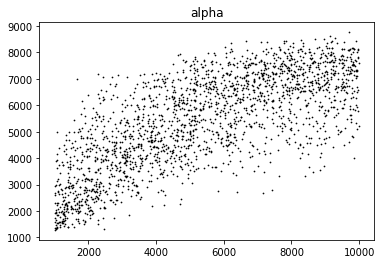

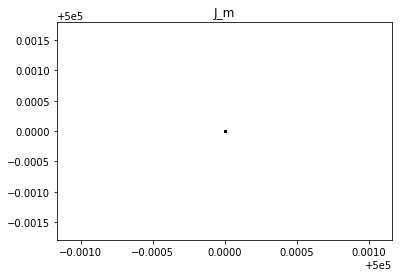

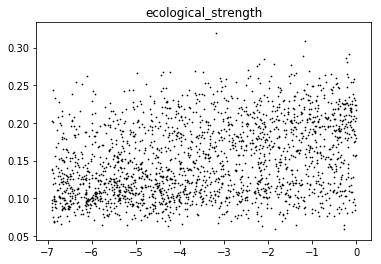

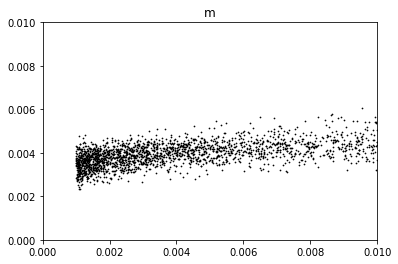

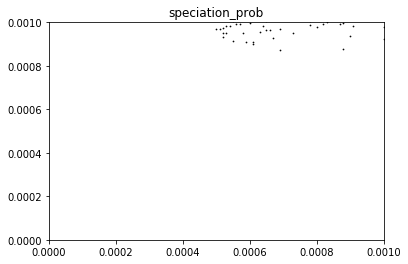

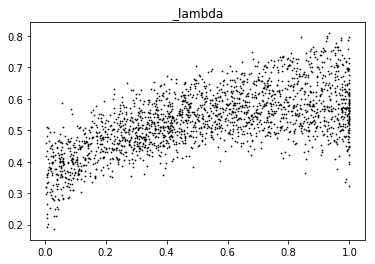

In [61]:
lims = {"m":0.01, "speciation_prob":0.001}
for i, p in enumerate(targets):
    fig, ax = plt.subplots()
    vscore = metrics.explained_variance_score(y.iloc[:, i], cv_preds[:, i])
    r2 = metrics.r2_score(y.iloc[:, i], cv_preds[:, i])
    print(p, vscore, r2)
    if p == "ecological_strength":
        ax.scatter(np.log(y.iloc[:, i]), cv_preds[:, i], c='black', marker='.', s=2)
    else:
        ax.scatter(y.iloc[:, i], cv_preds[:, i], c='black', marker='.', s=2)
    ax.set_title(p)
    if p in ["m", "speciation_prob"]:
        ax.set_xlim(0, lims[p])
        ax.set_ylim(0, lims[p])

In [108]:
[x for x in sim_df.columns if "pi" in x or "SGD" in x]

['pi_h1',
 'pi_h2',
 'pi_h3',
 'pi_h4',
 'mean_pi',
 'std_pi',
 'skewness_pi',
 'kurtosis_pi',
 'median_pi',
 'iqr_pi',
 'SGD_0',
 'SGD_1',
 'SGD_2',
 'SGD_3',
 'SGD_4',
 'SGD_5',
 'SGD_6',
 'SGD_7',
 'SGD_8',
 'SGD_9']